In [1]:
#print("Hello 10")
import math

inputs  = [1, 2, 3, 2.5]
weights = [ [0.2, 0.8, -0.5, 1],
            [0.5, -0.91, 0.26, -0.5],
            [-0.26, -0.27, 0.17, 0.87]]
biases = [2, 3, 0.5]



layer_outputs = []

#iterate each neuron and -> creates tupe of weights and bias
for neuron_weights, neuron_bias in zip(weights, biases):
    neuron_output = 0
    #iterate each input
    for n_input, weight in zip(inputs, neuron_weights):
        #sum the inputs and weights for the neuron
        neuron_output += n_input*weight
    #add the bias
    neuron_output += neuron_bias
    layer_outputs.append(neuron_output)
print(layer_outputs)



[4.8, 1.21, 2.385]


In [2]:
test = zip(weights, biases)
print(tuple(test))


(([0.2, 0.8, -0.5, 1], 2), ([0.5, -0.91, 0.26, -0.5], 3), ([-0.26, -0.27, 0.17, 0.87], 0.5))


In [3]:
#tensors, arrays and vectors
#list
l = [1,5,6,2]
lol = [[1,5,6,2],
       [3,2,1,3]]
lolol = [[[1,5,6,2],
       [3,2,1,3]],
         [[1,5,6,2],
       [3,2,1,3]],
         [[1,5,6,2],
       [3,2,1,3]] ]



In [15]:
import numpy as np
#dot products and vector additios
inputs  = [1, 2, 3, 2.5]
weights = [ [0.2, 0.8, -0.5, 1],
            [0.5, -0.91, 0.26, -0.5],
            [-0.26, -0.27, 0.17, 0.87]]
biases = [2, 3, 0.5]

outputs = np.dot(weights,inputs) +biases
print(outputs)

[4.8   1.21  2.385]


In [4]:
import numpy as np
#hidden layer
inputs  = [[1, 2, 3, 2.5],
           [2, 5, -1, 2],
           [-1.5, 2.7, 3.3, -0.8]]
weights = [ [0.2, 0.8, -0.5, 1],
            [0.5, -0.91, 0.26, -0.5],
            [-0.26, -0.27, 0.17, 0.87]]
biases = [2, 3, 0.5]
weights2 = [ [0.1, -0.14, 0.5],
            [-0.5, -0.12, -0.33],
            [-0.44, 0.73, -0.13]]
biases2 = [-1, 2, -0.5]


layer1_outputs = np.dot(inputs, np.array(weights).T) +biases
layer2_outputs = np.dot(layer1_outputs, np.array(weights2).T) +biases2
#print(layer1_outputs)
print(layer2_outputs)

[[ 0.5031  -1.33225 -2.03875]
 [ 0.2434  -2.2988  -5.7633 ]
 [-0.99314  1.1603  -0.35655]]


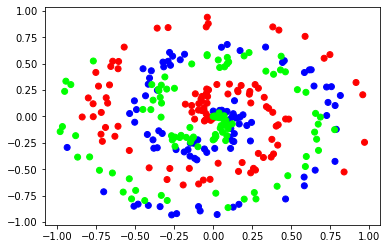

[[0.33333334 0.33333334 0.33333334]
 [0.33333316 0.3333332  0.33333364]
 [0.33333287 0.3333329  0.33333418]
 [0.3333326  0.33333263 0.33333477]
 [0.33333233 0.3333324  0.33333528]]
Loss:  1.0986104
Accuracy  0.34


In [1]:

import numpy as np
import nnfs
import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data

nnfs.init()
#desne is a fully connected layer
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        #initialize weights and biases
        self.weights = 0.01 *np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        # calculate output from inputs,weights, biases
        self.output = np.dot(inputs, self.weights) +self.biases

#rectified linear  __/
class Activation_ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0,inputs)


#casts the data to a probability e^value/total of e^i
class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs-np.max(inputs, axis=1, keepdims=True))

        probabilities = exp_values/np.sum(exp_values, axis = 1, keepdims=True)

        self.output = probabilities

class Loss:

    def calculate(self, output, y):
        sample_losses =self.forward(output, y)
        data_loss =np.mean(sample_losses)
        return data_loss

class Loss_CategoricalCrossEntropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)

        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
        #sparse data ie, the actual index
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        #one hot encoded data ie list of list
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods


#dataset
x,y = spiral_data(samples=100, classes=3)


plt.scatter(x[:,0], x[:,1], c=y, cmap='brg')
plt.show()

#dense with 2 inputs, 3 outputs
dense1 = Layer_Dense(2,3)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3,3)
activation2 = Activation_Softmax()
loss_function = Loss_CategoricalCrossEntropy()


dense1.forward(x)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
print(activation2.output[:5])

loss = loss_function.calculate(activation2.output, y)

print('Loss: ', loss)


predictions = np.argmax(activation2.output, axis=1)


if len(y.shape) ==2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions==y)

print('Accuracy ', accuracy)

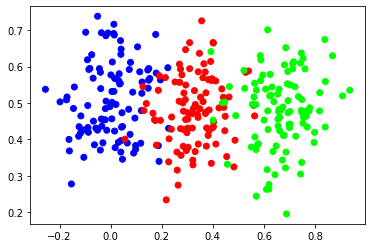

New sets of weights found, iteration:  0 
Loss:  1.0987684 
Accuracy 0.3333333333333333
New sets of weights found, iteration:  1 
Loss:  1.0987465 
Accuracy 0.3333333333333333
New sets of weights found, iteration:  5 
Loss:  1.0976487 
Accuracy 0.3333333333333333
New sets of weights found, iteration:  6 
Loss:  1.097202 
Accuracy 0.3333333333333333
New sets of weights found, iteration:  10 
Loss:  1.0938749 
Accuracy 0.3333333333333333
New sets of weights found, iteration:  19 
Loss:  1.0935849 
Accuracy 0.6666666666666666
New sets of weights found, iteration:  20 
Loss:  1.0908297 
Accuracy 0.3333333333333333
New sets of weights found, iteration:  21 
Loss:  1.0905013 
Accuracy 0.3333333333333333
New sets of weights found, iteration:  22 
Loss:  1.0879314 
Accuracy 0.3333333333333333
New sets of weights found, iteration:  24 
Loss:  1.0856307 
Accuracy 0.3333333333333333
New sets of weights found, iteration:  25 
Loss:  1.0801181 
Accuracy 0.35
New sets of weights found, iteration:  2

In [11]:

import numpy as np
import nnfs
import matplotlib.pyplot as plt
from nnfs.datasets import vertical_data

nnfs.init()

x,y = vertical_data(samples=100, classes=3)
plt.scatter(x[:,0], x[:,1], c=y, cmap='brg')
plt.show()


#dense with 2 inputs, 3 outputs
dense1 = Layer_Dense(2,3)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3,3)
activation2 = Activation_Softmax()
loss_function = Loss_CategoricalCrossEntropy()

lowest_loss = 99999999
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

for iteration in range(10000):
    dense1.weights += 0.05*np.random.randn(2,3)
    dense1.biases += 0.05*np.random.randn(1,3)
    dense2.weights += 0.05*np.random.randn(3,3)
    dense2.biases += 0.05*np.random.randn(1,3)

    dense1.forward(x)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    loss = loss_function.calculate(activation2.output, y)

    predictions = np.argmax(activation2.output, axis=1)
    accuracy = np.mean(predictions==y)

    if loss< lowest_loss:
        print("New sets of weights found, iteration: ", iteration, "\nLoss: ", loss, "\nAccuracy", accuracy)

        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()
        lowest_loss = loss
    else:

        #print("Here")
        dense1.weights = best_dense1_weights.copy()
        dense1.biases = best_dense1_biases.copy()
        dense2.weights = best_dense2_weights.copy()
        dense2.biases = best_dense2_biases.copy()



